In [1]:
import csv
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
import re
STOPWORDS = set(stopwords.words('english'))

print(tf.__version__)

2.9.1


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
vocab_size = 10000
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
TRAINING_SPLIT = .8

In [4]:
filePath = 'D:\Bismillah lolos Bangkit\Bismillah Bangkit Lancar\Dataset\my_dataset_fix.csv'
df = pd.read_csv(filePath)
df.head()

,Label,Authors,Author(s) ID,Title,Year,Source title,Volume,Issue,Art. No.,Page start,...,Cited by,DOI,Link,Author Keywords,Index Keywords,Document Type,Publication Stage,Open Access,Source,EID
0,Teknik,"Deng S., Hu R., Ye W.",36701056800;57212620394;57221781210;,State Evaluation Technology of Distribution Ne...,2020,Gaodianya Jishu/High Voltage Engineering,46,12,NaN,4430,...,4.0,10.13336/j.1003-6520.hve.20192008,https://www.scopus.com/inward/record.uri?eid=2...,Fault diagnosis; Measurement and control syste...,Cable jointing; Electric power system security...,Article,Final,NaN,Scopus,2-s2.0-85100211935
1,Teknik,"Song G., Li G., Yang H., Li H., Chen Y.",57220180612;7407048700;57220187707;57221546713...,Adaptive Control of Grid-connected Inverter in...,2020,Gaodianya Jishu/High Voltage Engineering,46,12,NaN,4455,...,NaN,10.13336/j.1003-6520.hve.20191686,https://www.scopus.com/inward/record.uri?eid=2...,Adaptive control; Global stability; Grid-conne...,Asymptotic stability; Control system stability...,Article,Final,NaN,Scopus,2-s2.0-85100137260
2,Teknik,"Khan Z.H., Khan W.A., Tang J., Sheremet M.A.",55845420338;57208847884;55760572600;12766763900;,Entropy generation analysis of triple diffusiv...,2020,Chemical Engineering Science,228,NaN,115980,NaN,...,20.0,10.1016/j.ces.2020.115980,https://www.scopus.com/inward/record.uri?eid=2...,Entropy generation; Horizontal plate; Irrevers...,Flow of fluids; Mass transfer; Porous material...,Article,Final,NaN,Scopus,2-s2.0-85088977941
3,Teknik,"Deleau T., Fechter M.H.H., Letourneau J.-J., C...",57218161588;57209575500;7006450306;6505808494;...,Determination of mass transfer coefficients in...,2020,Chemical Engineering Science,228,NaN,115960,NaN,...,4.0,10.1016/j.ces.2020.115960,https://www.scopus.com/inward/record.uri?eid=2...,High pressure; Mass transfer; Microfluidics; R...,Carbon dioxide; Fused silica; Mass transfer; R...,Article,Final,"All Open Access, Green",Scopus,2-s2.0-85088135310
4,Teknik,Durán A.,35993192100;,On a model for internal waves in rotating fluids,2020,Applied Mathematics and Nonlinear Sciences,3,2,NaN,627,...,2.0,10.2478/AMNS.2018.2.00048,https://www.scopus.com/inward/record.uri?eid=2...,concerved quantities; Petviashvili iteration; ...,Plasma flow; Rotational flow; Solitons; Two ph...,Article,Final,"All Open Access, Gold, Green",Scopus,2-s2.0-85069664183


In [5]:
def parse_data_from_file(filename):
    titles = []
    labels = []
    newdf =[]
    punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    with open(filename,'r') as csvfile:
      df = csv.reader(csvfile)
      next(df)
      for row in df:
        new_df = {}
        if row[0]== "Teknik":
          new_df['teknik']=1
          new_df['kesehatan']=0
          new_df['ekonomi']=0
          new_df['hukum']=0
        elif row[0]== "Kesehatan":
          new_df['teknik']=0
          new_df['kesehatan']=1
          new_df['ekonomi']=0
          new_df['hukum']=0
        elif row[0]== "Ekonomi":
          new_df['teknik']=0
          new_df['kesehatan']=0
          new_df['ekonomi']=1
          new_df['hukum']=0
        elif row[0]== "Hukum":
          new_df['teknik']=0
          new_df['kesehatan']=0
          new_df['ekonomi']=0
          new_df['hukum']=1
        title = row[3]
        title = title.lower()
        #labels.append(label)
        for word in STOPWORDS:
            token = ' ' + word + ' '
            title = title.replace(token, ' ')
            title = title.replace(' ', ' ')
            title = re.sub(r'[^\w\s]', '', title)
        new_df['title'] = title
        newdf.append(new_df)
        titles.append(title)
      """
      for label in labels:
        new_df['teknik'].append(label[0])
        new_df['kesehatan'].append(label[1])
        new_df['ekonomi'].append(label[2])
        new_df['hukum'].append(label[3])
      """
    return titles, labels, newdf

In [9]:
titles, labels, newdf = parse_data_from_file(filePath)

print(titles)
print(labels)

print(f"dataset contains {len(titles)} examples\n")

print(f"Text of second example should look like this:\n{titles[1]}\n")
print(f"Text of fourth example should look like this:\n{titles[3]}")

print(f"\nLabels of last 5 examples should look like this:\n{labels[-5:]}")
print(newdf)

UnicodeDecodeError: 'charmap' codec can't decode byte 0x9d in position 4483: character maps to <undefined>

In [10]:
def new_df(newdf):
  with open('/content/new_df.csv','w') as csvfile:
    Fieldnames = ['teknik','kesehatan','ekonomi','hukum','title']
    dataframe = csv.DictWriter(csvfile, fieldnames=Fieldnames)
    dataframe.writerow({'teknik':'teknik','kesehatan':'kesehatan','ekonomi':'ekonomi','hukum':'hukum','title':'title'})
    for row in newdf:
      dataframe.writerow(row)

In [8]:
new_df(newdf)

In [9]:
ndf = pd.read_csv('/content/new_df.csv')
ndf.head()

,teknik,kesehatan,ekonomi,hukum,title
0,1,0,0,0,state evaluation technology distribution netwo...
1,1,0,0,0,adaptive control gridconnected inverter microg...
2,1,0,0,0,entropy generation analysis triple diffusive f...
3,1,0,0,0,determination mass transfer coefficients highp...
4,1,0,0,0,on model internal waves rotating fluids


#LOAD DATA

In [10]:
dataset_path = '/content/new_df.csv'
dataset_df = pd.read_csv(dataset_path)
print("Shape:", dataset_df.shape)

Shape: (8000, 5)


In [11]:
text_df = dataset_df['title']
features = dataset_df.columns[:4]
print(features)
label_df = dataset_df[features]
num_classes = len(features)
print("Number of classes:", num_classes)

Index(['teknik', 'kesehatan', 'ekonomi', 'hukum'], dtype='object')
Number of classes: 4


In [12]:
train_text, val_text, train_label, val_label = train_test_split(text_df, label_df, test_size=0.50, random_state=37)
print(train_text.shape[0], "data for training")
print(val_text.shape[0], "data for validation")

4000 data for training
4000 data for validation


In [13]:
def seq_pad_and_trunc(titles, padding, truncating, maxlen):
    tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
    tokenizer.fit_on_texts(titles)
    titles = tokenizer.texts_to_sequences(titles)
    pad_trunc_sequences = pad_sequences(titles, maxlen=maxlen, truncating=truncating,padding=padding)
    return pad_trunc_sequences

In [14]:
train_seq = seq_pad_and_trunc(train_text, padding_type, trunc_type, max_length)
val_seq = seq_pad_and_trunc(val_text, padding_type, trunc_type, max_length)

print(f"Padded and truncated training sequences have shape: {train_seq}\n")
print(f"Padded and truncated validation sequences have shape: {val_seq.shape}")

Padded and truncated training sequences have shape: [[4308 2711 4309 ...    0    0    0]
 [  36  144  113 ...    0    0    0]
 [1079 1080 1291 ...    0    0    0]
 ...
 [1205  143    8 ...    0    0    0]
 [ 282  745    1 ...    0    0    0]
 [ 198   30  888 ...    0    0    0]]

Padded and truncated validation sequences have shape: (4000, 200)


In [15]:
batch_size = 32
train_ds = tf.data.Dataset.from_tensor_slices((train_seq, train_label.values))
train_ds = train_ds.shuffle(train_text.shape[0] // 4).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((val_seq, val_label.values))
val_ds = val_ds.shuffle(val_text.shape[0] // 4).batch(batch_size)

In [36]:
def create_model(num_words, embedding_dim, maxlen):
    model = tf.keras.Sequential([ 
      tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
      tf.keras.layers.GlobalAveragePooling1D(),
      tf.keras.layers.Dense(516, activation='relu'),
      tf.keras.layers.Dense(4, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', #sgd/rmsprop
                  metrics=['accuracy']) 

    ### END CODE HERE

    return model

In [37]:
model = create_model(vocab_size, embedding_dim, max_length)

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 64)           640000    
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 516)               33540     
                                                                 
 dense_3 (Dense)             (None, 4)                 2068      
                                                                 
Total params: 675,608
Trainable params: 675,608
Non-trainable params: 0
_________________________________________________________________


In [39]:
history = model.fit(train_ds, epochs=50, batch_size=64, validation_data=(val_ds))

Epoch 1/50
125/125 [==============================] - 1s 7ms/step - loss: 1.3859 - accuracy: 0.2558 - val_loss: 1.3860 - val_accuracy: 0.2463
Epoch 2/50
125/125 [==============================] - 1s 8ms/step - loss: 1.3646 - accuracy: 0.3722 - val_loss: 1.3719 - val_accuracy: 0.3043
Epoch 3/50
125/125 [==============================] - 1s 8ms/step - loss: 1.0932 - accuracy: 0.6895 - val_loss: 1.3164 - val_accuracy: 0.3665
Epoch 4/50
125/125 [==============================] - 1s 6ms/step - loss: 0.5871 - accuracy: 0.8520 - val_loss: 1.3941 - val_accuracy: 0.3860
Epoch 5/50
125/125 [==============================] - 1s 7ms/step - loss: 0.3182 - accuracy: 0.9298 - val_loss: 1.5478 - val_accuracy: 0.3815
Epoch 6/50
125/125 [==============================] - 1s 8ms/step - loss: 0.2160 - accuracy: 0.9490 - val_loss: 1.6616 - val_accuracy: 0.3898
Epoch 7/50
125/125 [==============================] - 1s 8ms/step - loss: 0.1541 - accuracy: 0.9643 - val_loss: 1.7771 - val_accuracy: 0.3880
Epoch 

In [20]:
model.save('/content/my_model.h5')

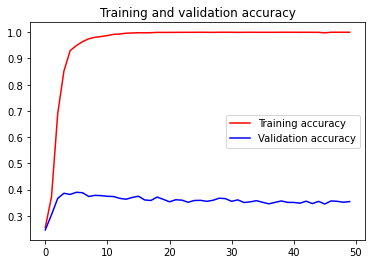

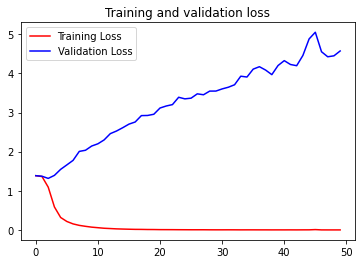

In [40]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [22]:
def cleaning_stopwords(title):
  title = title.lower()
  for word in STOPWORDS:
    token = ' ' + word + ' '
    Title = title.replace(token, ' ')
    title = title.replace(' ', ' ')
    title = re.sub(r'[^\w\s]', '', title)
  return title

In [23]:
  model = tf.keras.models.load_model('/content/my_model.h5')

In [34]:
def predict(title):
  class_names = ['teknik','kesehatan','ekonomi','hukum']
  clean_words = cleaning_stopwords(title)
  try_seq = seq_pad_and_trunc(clean_words, padding_type, trunc_type, max_length)
  prediction = model.predict(try_seq)
  index = prediction[0].argmax()
  label = class_names[index]
  return label


In [35]:
x = "From incidence to strategy: A systematic review in playing-related musculoskeletal disorders"
print(predict(x))

teknik
